<a href="https://colab.research.google.com/github/Yutong-Lu/Datathon-4/blob/main/Rachel_Yeung_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
import plotly.express as px
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# !pip install torch

# importing torch as t
import torch as t
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

##Upload Dataset

In [3]:
# Run code on Colab
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

Saving datathon4.csv to datathon4.csv


In [4]:
# Read the dataset into a Pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded['datathon4.csv']))

#Ensure correct dataset is being inputted
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


##Initial Descriptive Analysis of Dataset

In [5]:
# Getting the shape of the dataframe
print(df.shape)

# List the columns of the dataframe
print(df.columns)

# Check for missing values in the dataset
print(df.isna().sum())

# Display the data types of each column
df.dtypes

# Display overall summary statistics
print(df.describe())

(91713, 186)
Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)
encounter_id                      0
patient_id                        0
hospital_id                       0
hospital_death                    0
age                            4228
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 186, dtype: int64
        encounter_id     patient_id   hospital_id  hospital_death  \
count   91713.000000   91713.000000  91713.000000    91713.000000   
mean    65606.079280   65

In [ ]:
df['hospital_death'].mean()

0.08630183289173836

##Data Preparation

###Compare Ratio of Hospital Death

In [6]:
print(df.groupby('hospital_death').size()) # outcome is very unbalanced

hospital_death
0    83798
1     7915
dtype: int64


###Drop Columns Not Used for Analysis

In [7]:
# Create a subset with manual feature selection
df = df.drop(['encounter_id', 'patient_id', 'hospital_id','icu_id',
               'apache_3j_bodysystem', 'apache_2_bodysystem', 'readmission_status',
                'apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob'], axis=1)

###Define Target, Categorical, and Numerical Columns

In [8]:
# Define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'

# List of columns that contain categorical data
categorical_columns = ['ethnicity', 'gender','hospital_admit_source', 'icu_admit_source',
                       'icu_stay_type', 'icu_type']

# List of columns that contain numerical data (excluding categorical columns and the target column)
numerical_columns = [c for c in df.columns if c not in categorical_columns and c != target_column]

for c in categorical_columns:
    print(df[c].unique())

['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']
['M' 'F' nan]
['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']
['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
['admit' 'readmit' 'transfer']
['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']


###Group Categorical Data by Numbers

In [9]:
df['ethnicity'] = df['ethnicity'].replace({'Caucasian': 1, 'Hispanic': 2, 'African American': 3, 'Asian': 4, 'Native American': 5, 'Other/Unknown':6})
df['gender'] = df['gender'].replace({'M': 1, 'F': 2})
df['hospital_admit_source'] = df['hospital_admit_source'].replace({'Floor': 1, 'Emergency Department': 2, 'Operating Room': 3, 'Direct Admit': 4, 'Other Hospital': 5,
                                 'Other ICU':6, 'ICU to SDU': 7, 'Recovery Room': 8, 'Chest Pain Center': 9, 'Step-Down Unit (SDU)': 10, 'Acute Care/Floor': 11,
                                 'PACU': 12, 'Observation': 13, 'ICU': 14, 'Other': 15})
df['icu_admit_source'] = df['icu_admit_source'].replace({'Floor': 1, 'Accident & Emergency': 2, 'Operating Room / Recovery': 3, 'Other Hospital': 4, 'Other ICU':5})
df['icu_stay_type'] = df['icu_stay_type'].replace({'admit': 1, 'readmit': 2, 'transfer': 3})
df['icu_type'] = df['icu_type'].replace({'CTICU': 1, 'Med-Surg ICU': 2, 'CCU-CTICU': 3, 'Neuro ICU': 4, 'MICU': 5, 'SICU': 6, 'Cardiac ICU': 7, 'CSICU': 8})

df.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,0,68.0,22.73,0,1.0,1.0,180.3,1.0,1.0,1,...,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,77.0,27.42,0,1.0,2.0,160.0,1.0,1.0,1,...,51.0,51.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,25.0,31.95,0,1.0,2.0,172.7,2.0,2.0,1,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,81.0,22.64,1,1.0,2.0,165.1,3.0,3.0,1,...,337.0,337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,19.0,NaN,0,1.0,1.0,188.0,NaN,2.0,1,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Convert NA Values to Zero

In [10]:
df.fillna(0, inplace = True)

# Check for missing values in the dataset
print(df.isna().sum())

hospital_death                 0
age                            0
bmi                            0
elective_surgery               0
ethnicity                      0
                              ..
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
Length: 177, dtype: int64


##Neural Networks

In [16]:
# Randomly sample 70% of the data for training
train_data = df.sample(frac = .7, random_state=10)

# Use the remaining 30% for testing
test_data = df.drop(train_data.index)

# Check the mean of the 'DEATH_EVENT' column in both training and testing data
train_data['hospital_death'].mean()
test_data['hospital_death'].mean()

# Data Preparation

# Extract the 'DEATH_EVENT' column as the target variable for training and testing
Y_train = train_data['hospital_death'].to_numpy()
Y_test = test_data['hospital_death'].to_numpy()

# Extract the features (excluding 'DEATH_EVENT') for training and testing
X_train = train_data.drop('hospital_death', axis=1).to_numpy()
X_test = test_data.drop('hospital_death', axis=1).to_numpy()

# Standardize the features to have zero mean and unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [17]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 32
hidden_units_layer_2 = 32

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((176, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

In [18]:
# Define the forward pass of the neural network
def forward(input):
    # First hidden layer with tanh activation
    out = tanh(input @ W1 + B1)

    # Second hidden layer with tanh activation
    out = tanh(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

In [26]:
# Convert the training data to PyTorch tensors
X = t.Tensor(X_train).type(t.float32)
Y = t.Tensor(Y_train).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 200
learning_rate = 0.01
batch_size = 32

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

In [27]:
train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Text(0, 0.5, 'loss')

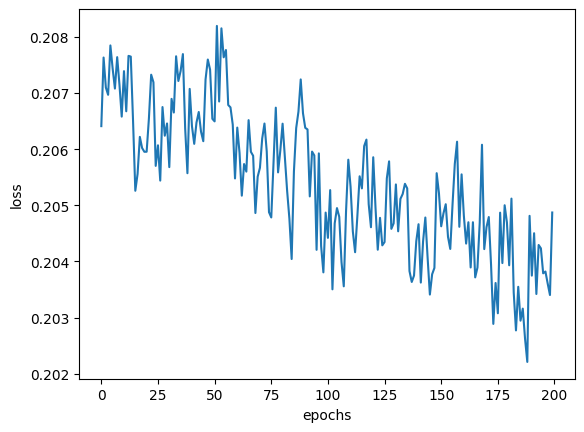

In [28]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

In [29]:
# Evaluate Model Performance on Validation Data

# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y = t.Tensor(Y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the validation loss
    print(loss.item())

    # Now, evaluate the model on the training data
    X = t.Tensor(X_train).type(t.float32)  # Convert training features to a PyTorch tensor
    Y = t.Tensor(Y_train).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs = forward(X)  # Pass training data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the training loss
    print(loss.item())

0.22418683767318726
0.20524275302886963


In [30]:
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Regularization
# Deep neural networks are prone to overfitting if there is not much data available during training.

# Define hyperparameters
number_of_input_features = 176
number_of_hidden_units = 5
epochs = 100
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

# Prepare the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, 1),  # Another linear layer
    nn.Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Epoch 0/100 ---> Train Accuracy: 0.9147806167602539, Validation Accuracy: 0.9141528010368347
Epoch 1/100 ---> Train Accuracy: 0.9196716547012329, Validation Accuracy: 0.9181870818138123
Epoch 2/100 ---> Train Accuracy: 0.9210423827171326, Validation Accuracy: 0.9194955229759216
Epoch 3/100 ---> Train Accuracy: 0.9138304591178894, Validation Accuracy: 0.9133895635604858
Epoch 4/100 ---> Train Accuracy: 0.9138304591178894, Validation Accuracy: 0.9133895635604858
Epoch 5/100 ---> Train Accuracy: 0.9138304591178894, Validation Accuracy: 0.9133895635604858
Epoch 6/100 ---> Train Accuracy: 0.9127712249755859, Validation Accuracy: 0.9123718738555908
Epoch 7/100 ---> Train Accuracy: 0.9138304591178894, Validation Accuracy: 0.9133895635604858
Epoch 8/100 ---> Train Accuracy: 0.9178024530410767, Validation Accuracy: 0.9169513583183289
Epoch 9/100 ---> Train Accuracy: 0.9138304591178894, Validation Accuracy: 0.9133895635604858
Epoch 10/100 ---> Train Accuracy: 0.9138304591178894, Validation Accur

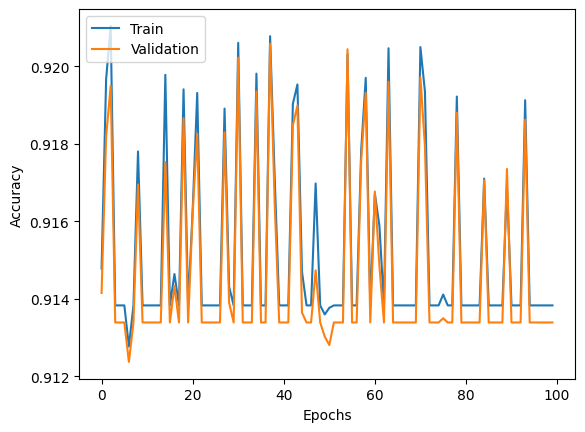

In [31]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()